# Bayesian Linear Regression

In this notebook we will apply the framework of Bayesian statistics to linear regression.

<img src="BLR.png">

With contrast to the linear least squares estimation techniques like OLS, Bayesian linear regession produces not a single point estimate for the "best" values of the regression coefficients but an entire posterior distribution, completely describing the uncertainty surrounding the quantity.

# Base assumptions about posit linear model.

Given some phenomenons, coded into matrices $X$, $Y$<br>

$\textbf{1)}$ Relationship between phenomenons from $X$ and $Y$ is linear, but gathered data is infected by some noise, which is coded into unobserved random variable $\epsilon$.<br>
By $\epsilon$ we also signify matrix of individual noises, which correspond to observed phenomenons.<br>
Described dependence can be writen, like this
$$Y = X \cdot W + \epsilon$$
Which is also called the dependency hypothesis.
Occured $W$ represent latent
<br>
<br>
<br>
$\textbf{2)}$ Noises that have infected the collected data, come from distributions with the same variance. It is also called homoscedasticity.
<br>
<br>
<br>
$\textbf{3)}$ Errors of the response variables are uncorrelated/independent with each other.
<br>
<br>
<br>
$\textbf{4)}$ Features representing the phenomena in $ X $ are linearly independent. Number of records in $X$ is greater than number of parameters(regression coefficients) in model.

# Assumptions in Bayesian linear regression
Assumption of 
$\varepsilon _{i}\sim N(0,\sigma ^{2})$<br>
leads to an explicit likelihood distribution about Y, given X and parameters.

By means of the first and fourth points of the previous paragraph, we are able to obtain an explicit formula for the parameter $W$, which presents itself as 
$$W = (X^TX)^{-1}X^T(Y-\epsilon)$$

Stating that the available sample size is reason enough to accept the estimation of the parameter $W$, we get 
$${\widehat W} = (X^TX)^{-1}X^T(Y)$$
This estimation is fully dependent on the collected sample of observed phenomena, and is not subject to any probability assessment.

However, the Bayesian approach is not satisfied with point estimation, wishing to examine the validity of the results obtained. The opportunity for such meta-studies is, however, possible when, first of all, an arbital environment of considerations is established. The concept of The prior belief is introduced here, which defines the beginning of inference from the arbitrary assumption of the form of the distribution under consideration.
This assumption, together with the likelihood and onymous theorem of this approach (Bayes' theorem), leads to the posteriori of the parameter $ W $ by the following formula $P(W|X) = \large\frac{P(X|W)P(W)}{P(X)}$

In [1]:
import inferpy as inf
import tensorflow as tf
import pandas as pd

In [2]:
@inf.probmodel
def lr_bpmodel(x_dim):
    w = inf.Normal(loc = tf.zeros(shape=[x_dim, 1]), scale=1, name="w")
    w0 = inf.Normal(loc = 0, scale=1, name="w0")
    
    with inf.datamodel():
        x = inf.Normal(loc = tf.ones(shape=[x_dim]), scale=1, name="x")
        y = inf.Normal(loc = w0 + x @ w, scale=1.0, name="y")
        
@inf.probmodel      
def bqmodel(x_dim):
    qw0_loc = inf.Parameter(initial_value=0., name="qw0_loc")
    qw0_scale = tf.math.softplus(features=inf.Parameter(initial_value=1., name="qw0_scale"))
    qw0 = inf.Normal(loc=qw0_loc, scale=qw0_scale, name="w0")

    qw_loc = inf.Parameter(initial_value=tf.zeros(shape=[x_dim, 1]), name="qw_loc")
    qw_scale = tf.math.softplus(features=inf.Parameter(initial_value=tf.ones(shape=[x_dim, 1]), name="qw_scale"))
    qw = inf.Normal(loc=qw_loc, scale=qw_scale, name="w")


# Data preparation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv("housing.csv", delim_whitespace=True, header=None, names=names)
print(dataset.shape)
dataset.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


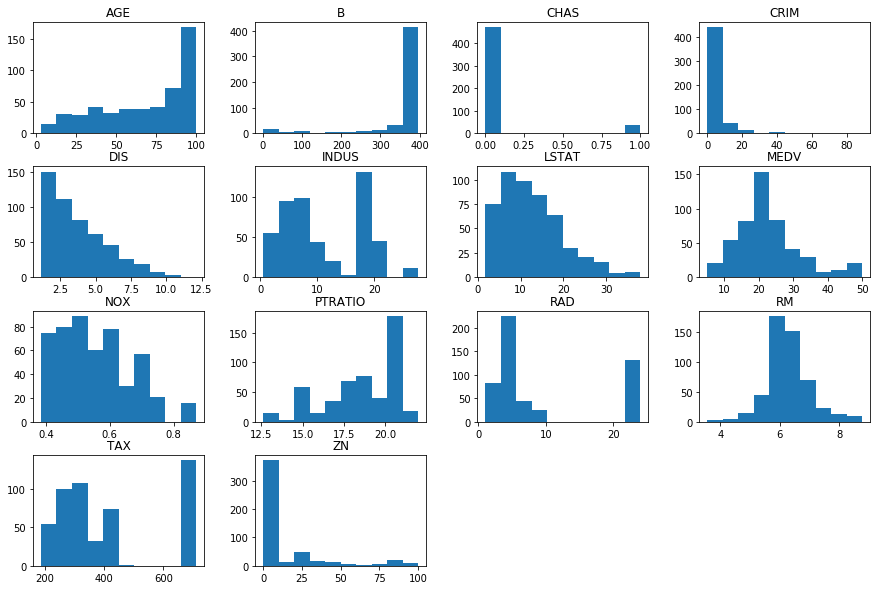

In [6]:
# histograms
dataset.hist(bins=10,figsize=(15,10),grid=False);

In [7]:
TARGET = "MEDV"
dataset = dataset.drop(['CRIM','ZN','INDUS','NOX','AGE','DIS','RAD'], axis = 1)
x_data, y_data = dataset.drop(labels=TARGET, axis=1).values, dataset[TARGET].values
y_data = y_data.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

# Fitting of posterior distribution parameters

In [8]:
lr_bmodel = lr_bpmodel(x_dim=x_train.shape[1])

VI = inf.inference.VI(bqmodel(x_train.shape[1]), epochs=30000)
lr_bmodel.fit({"x": x_train, "y":y_train}, VI)

W0816 18:57:58.133157 140671609747264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/prob_model.py:62: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0816 18:57:58.183075 140671609747264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/random_variable.py:430: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0816 18:57:58.212707 140671609747264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 18:57:58.298041 140671609747264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/prob_model.py:144: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0816 18:57:58.587550 140671609747264 deprecation_w


 0 epochs	 65786356.0....................
 200 epochs	 62942248.0....................
 400 epochs	 125641016.0....................
 600 epochs	 65509720.0....................
 800 epochs	 103393224.0....................
 1000 epochs	 112013352.0....................
 1200 epochs	 65702988.0....................
 1400 epochs	 166137680.0....................
 1600 epochs	 69697056.0....................
 1800 epochs	 86935944.0....................
 2000 epochs	 148967584.0....................
 2200 epochs	 63510552.0....................
 2400 epochs	 64479160.0....................
 2600 epochs	 127558680.0....................
 2800 epochs	 62143244.0....................
 3000 epochs	 64302240.0....................
 3200 epochs	 118109944.0....................
 3400 epochs	 64854660.0....................
 3600 epochs	 72110928.0....................
 3800 epochs	 85167696.0....................
 4000 epochs	 73770248.0....................
 4200 epochs	 63893488.0....................
 4400 epo

In [10]:
# extract the parameters of the posterior
lr_bmodel.posterior(["w", "w0"]).parameters()

{'w0': {'name': 'w0',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 0.37569955,
  'loc': 1.248945},
 'w': {'name': 'w',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.41308242],
         [0.08587791],
         [0.00189232],
         [0.03228379],
         [0.00214537],
         [0.03646533]], dtype=float32),
  'loc': array([[ 4.5333991e+00],
         [ 2.1196265e+00],
         [ 1.1395563e-03],
         [ 2.9572901e-01],
         [ 2.9363347e-02],
         [-7.0499170e-01]], dtype=float32)}}